## **Mount to drive and cd to repo**

In [1]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [2]:
!pip install datasketch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.6 MB/s eta 0:00:00


In [3]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.3 MB/s eta 0:00:00


## **Load data and do some basic methods to understand data**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('clean_sample_data.csv')


In [6]:
print(df.columns)
df['Clean_Review'].values[0]

Index(['overall', 'reviewText', 'Clean_Review'], dtype='object')


'incredible company place product market buggy this.\n\nbought family pack instal first computer configure backup computer even backup fails everything green main dashboard.\na simple change parameter backup possible without corrupt backups.\nbackup network server work ti keep fail connect server even configure backup problem access server.\nbackup network server take eternity network usage crash backup configuration corruption.\n\nthis software unusable buy look alternative'

In [7]:
print(df.shape)

(3354, 3)


In [8]:
df.head()

,overall,reviewText,Clean_Review
0,1.0,It is incredible that in 2014 a company can pl...,incredible company place product market buggy ...
1,1.0,"I am afraid to install it on my system,I have ...",afraid install systemi bit window os...system ...
2,1.0,I upgraded to X2 thinking that the bugs had be...,upgraded thinking bug work software take forev...
3,1.0,The tech specs say that Windows XP Pro is suff...,tech spec say window xp pro sufficient wrong w...
4,1.0,Why did we have to do away with the good old d...,away good old disc great booster norton use si...


## **Quick Data Analysis**

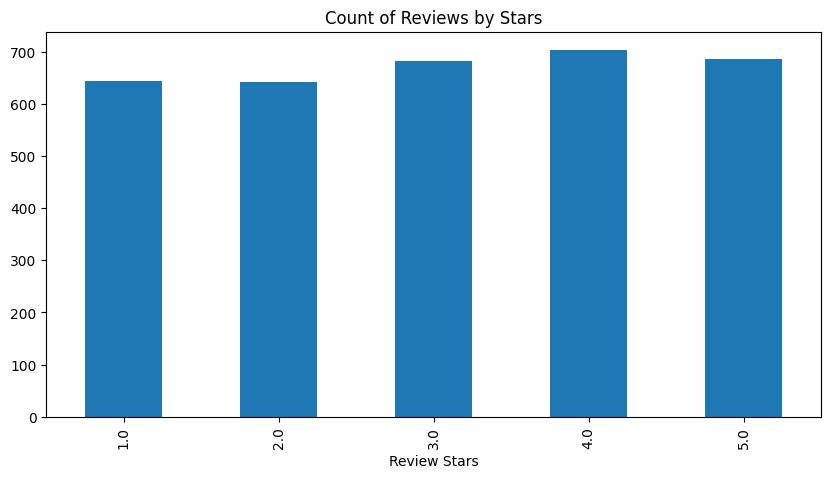

In [10]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar',title='Count of Reviews by Stars',
                                               figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

## **NLTK Set Up**

In [14]:
import nltk
nltk.download('punkt')

# loop over each line of the DataFrame，tokenize each line
tokenized_texts = df['reviewText'].apply(lambda x: nltk.word_tokenize(str(x)))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Use Word2Vec method for embedding and K-means clustering**

In [15]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = model.wv

In [16]:
from sklearn.cluster import KMeans

# Assuming you want to create 5 clusters
kmeans = KMeans(n_clusters=3)
# Fit the model
X = word_vectors.vectors
kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.labels_
print(labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2 2 2 ... 1 1 1]


## visualize the results using PCA

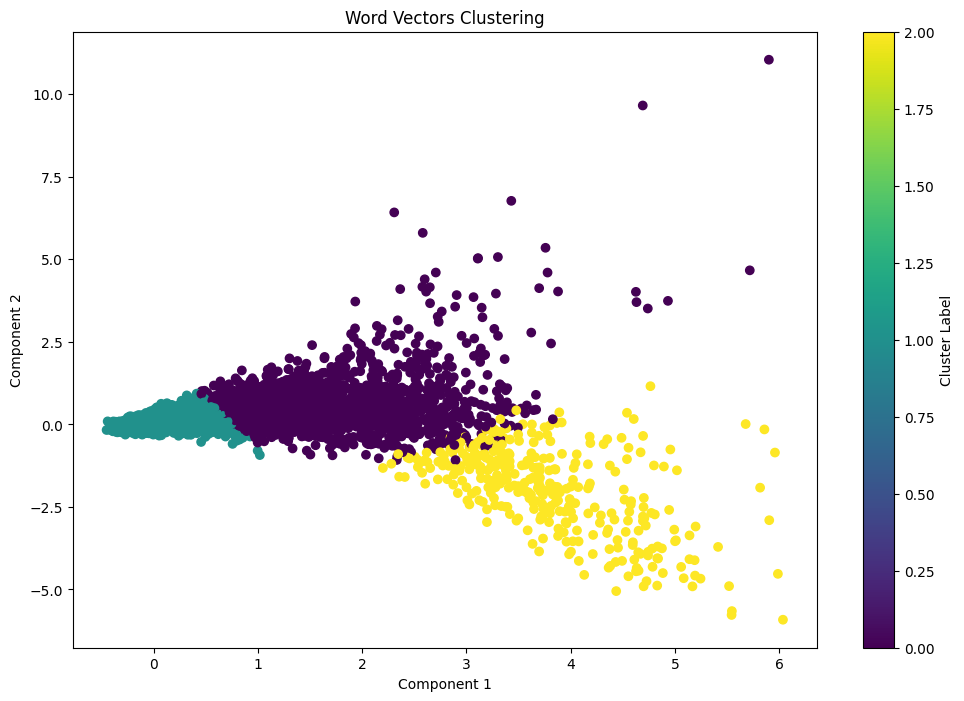

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X)
plt.figure(figsize=(12, 8))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Word Vectors Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


## **Use Bert for embedding and K-means clustering**

In [35]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [37]:
import torch

def encode_sentences(sentences, max_length=512):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt',
                        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


# Example usage
input_ids, attention_masks = encode_sentences(df)
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)

# `outputs` is a tuple, we only need the first element, which contains
# the embeddings.
embeddings = outputs[0]



In [43]:
averaged_embeddings = embeddings.mean(dim=0).detach().numpy()

# Define the number of clusters
num_clusters = 3

# Apply K-Means
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(averaged_embeddings)
labels = kmeans.labels_
print(labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1
 0 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0
 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 2 1 1 0 0 1 1 1
 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0
 0 0 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1
 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 2 2 0 2 1 1 1 0 0 1 0 1 1 0 0 1 1 2 2 2 1 0
 0 1 1 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 0 2 2 1 2 0 0 2 2 1 1 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 1 1 0 0 2 2 2 2 2 2 2 2 2 2 2 2 1 2 0 0 0 1 1 0 0 0 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 0 0 0 2 2 2 2 0 2 2 1 1 1 0 0 1 0 1 0 0 2 2
 2 2 2 2 2 2 0 2 2 1 1 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 0 0 0 1 2 0 0 2 0 2 2 2 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1
 0 0 1 1 1 0 2 1 0 0 1 0 0 0 0 1 0 0 0 1 0 2 2 2 2 2 2 1 0 2 2 2 2 2 2 2 0
 2 2 2 2 0 2 2 1 0 0 0 1 1 1 0 0 0 0 0 2 2 2 2 2 2 2 2 2 0 0 1 0 0 2 2 2 2
 2 2 2 2 2 1 1 0 0 0 1 1 

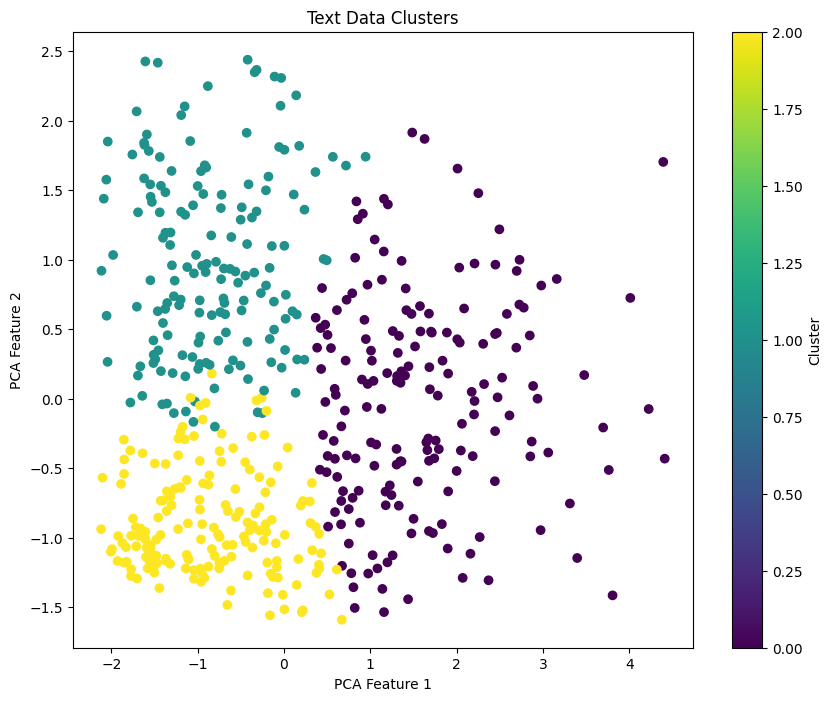

In [44]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(averaged_embeddings)  # or pooled_embeddings

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')
plt.title('Text Data Clusters')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster')
plt.show()

